In [34]:
%run ../../Environment/environment.ipynb

/home/lucifer/Desktop/Studienarbeit/Studienarbeit/Agents/A2C
Notebook ausgeführt


In [35]:
import gym
import optuna
import numpy as np
import pandas as pd
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.vec_env import DummyVecEnv

In [36]:
seed = 42
SEED  = seed % (2**32 - 1)
print("SEED:", SEED)

SEED: 42


# CSV Datem einlesen


In [37]:

train_data = pd.read_csv("../../Transform_data/stand_data/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("../../Transform_data/stand_data/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

print("✅ Trainings- und Testdaten erfolgreich geladen.")

✅ Trainings- und Testdaten erfolgreich geladen.


# TradingEnv erstellen 

In [38]:
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

print("✅ Environment erfolgreich erstellt.")

Seed in the environment: 42
✅ Environment erfolgreich erstellt.


/home/lucifer/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Optuna


In [39]:
"""

# Für Hyperparameter-Tuning nutzen wir test_data als Validierungsdatensatz.
valid_data = test_data.copy()

# -------------------------------
# Evaluation Helper Function
# -------------------------------
def evaluate_agent(model, env, n_eval_episodes=5):
    episode_rewards = []
    for _ in range(n_eval_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            obs, info = reset_result
        else:
            obs = reset_result
        done = False
        total_reward = 0.0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            if len(step_result) == 5:
                obs, reward, done, truncated, info = step_result
            else:
                obs, reward, done, info = step_result
            total_reward += reward
        episode_rewards.append(total_reward)
    return np.mean(episode_rewards)

# -------------------------------
# Hyperparameter Tuning with Optuna (für A2C)
# -------------------------------
def objective(trial):
    # Sample hyperparameters for A2C
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    n_steps = trial.suggest_categorical("n_steps", [5, 10, 16, 32, 64])
    ent_coef = trial.suggest_float("ent_coef", 1e-6, 0.01, log=True)
    vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 1.0)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.99)

    # Trainingsumgebung
    env_train = DummyVecEnv([lambda: TradingEnv(
        data=train_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../../Transform_data/scaler.pkl",
        default_seed=SEED
    )])

    # Validierungsumgebung
    env_valid = DummyVecEnv([lambda: TradingEnv(
        data=valid_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../../Transform_data/scaler.pkl",
        default_seed=SEED
    )])

    # A2C Modell
    model = A2C(
        "MlpPolicy",
        env_train,
        learning_rate=learning_rate,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm,
        gae_lambda=gae_lambda,
        verbose=0,
        seed=SEED,
    )

    # Training
    model.learn(total_timesteps=10000, log_interval=1)

    # Evaluation
    mean_reward = evaluate_agent(model, env_valid, n_eval_episodes=5)
    return mean_reward

# Optuna-Studie starten
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_trial.params)

"""

'\n\n# Für Hyperparameter-Tuning nutzen wir test_data als Validierungsdatensatz.\nvalid_data = test_data.copy()\n\n# -------------------------------\n# Evaluation Helper Function\n# -------------------------------\ndef evaluate_agent(model, env, n_eval_episodes=5):\n    episode_rewards = []\n    for _ in range(n_eval_episodes):\n        reset_result = env.reset()\n        if isinstance(reset_result, tuple):\n            obs, info = reset_result\n        else:\n            obs = reset_result\n        done = False\n        total_reward = 0.0\n        while not done:\n            action, _states = model.predict(obs, deterministic=True)\n            step_result = env.step(action)\n            if len(step_result) == 5:\n                obs, reward, done, truncated, info = step_result\n            else:\n                obs, reward, done, info = step_result\n            total_reward += reward\n        episode_rewards.append(total_reward)\n    return np.mean(episode_rewards)\n\n# ------------

In [ ]:
version = 2  # <---- Version Auswählen


if version == 1:
    # Modell 1 – Standard A2C-Agent (Baseline)
    model = A2C("MlpPolicy", env, verbose=1, seed=SEED)
    model.learn(total_timesteps=100_000)
    model.save("A2C_Model1_100K")

elif version == 2:
    # Modell 2 – Optuna-optimierte Parameter 
    model = A2C("MlpPolicy", env,
                 learning_rate=0.0007779629901797063, 
                 gamma=0.9759660718938183,
                 n_steps=10, 
                 ent_coef =2.063477042692161e-06, 
                 vf_coef=0.2879544697496038, 
                 max_grad_norm=0.7221373760511755, 
                 gae_lambda = 0.9364764341056717,
                 verbose=1,
                 seed=SEED)
    model.learn(total_timesteps=100_000)
    model.save("A2C_Model2_100K")

elif version == 3:
    # Modell 3 – Agent soll mehr ausprobieren
    model = A2C("MlpPolicy",
                env,
                seed=SEED,
                learning_rate=0.0007,           # moderat
                n_steps=5,                      # kurze Entscheidungsspanne → mehr Feedback
                gamma=0.99,
                gae_lambda=0.95,
                ent_coef=0.05,                  # sehr hohe Entropie → erkundet mehr
                vf_coef=0.5,
                max_grad_norm=0.5,
                use_rms_prop=True,
                normalize_advantage=True,
                verbose=1)
    model.learn(total_timesteps=100_000)
    model.save("A2C_Model3_100K")

elif version == 4:
    # Modell 4 – Weniger chaotisches Verhalten – Fokus auf stabile Policy-Updates.
    model = A2C("MlpPolicy",
                env,
                seed=SEED,
                learning_rate=0.0001,           # deutlich niedriger
                n_steps=20,                     # längere Rollouts
                gamma=0.95,                     # konservativere Gewichtung zukünftiger Rewards
                gae_lambda=0.9,
                ent_coef=0.0001,                # fast kein Exploration-Drang
                vf_coef=0.25,
                max_grad_norm=0.3,
                use_rms_prop=True,
                normalize_advantage=True,
                verbose=1)
    model.learn(total_timesteps=100_000)
    model.save("A2C_Model4_100K")

else:
    raise ValueError("Ungültige Agenten-Version: nur 1 bis 4 erlaubt")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Seed in the environment: 42
------------------------------------
| time/                 |          |
|    fps                | 323      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.03    |
|    explained_variance | -62.6    |
|    learning_rate      | 0.000778 |
|    n_updates          | 99       |
|    policy_loss        | -0.00139 |
|    value_loss         | 0.00378  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 340      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.95    |
|    explained_variance | -2.52    |
|    learning_rate      | 0

# Backtesting

## Trainigsdaten

Seed in the environment: 42


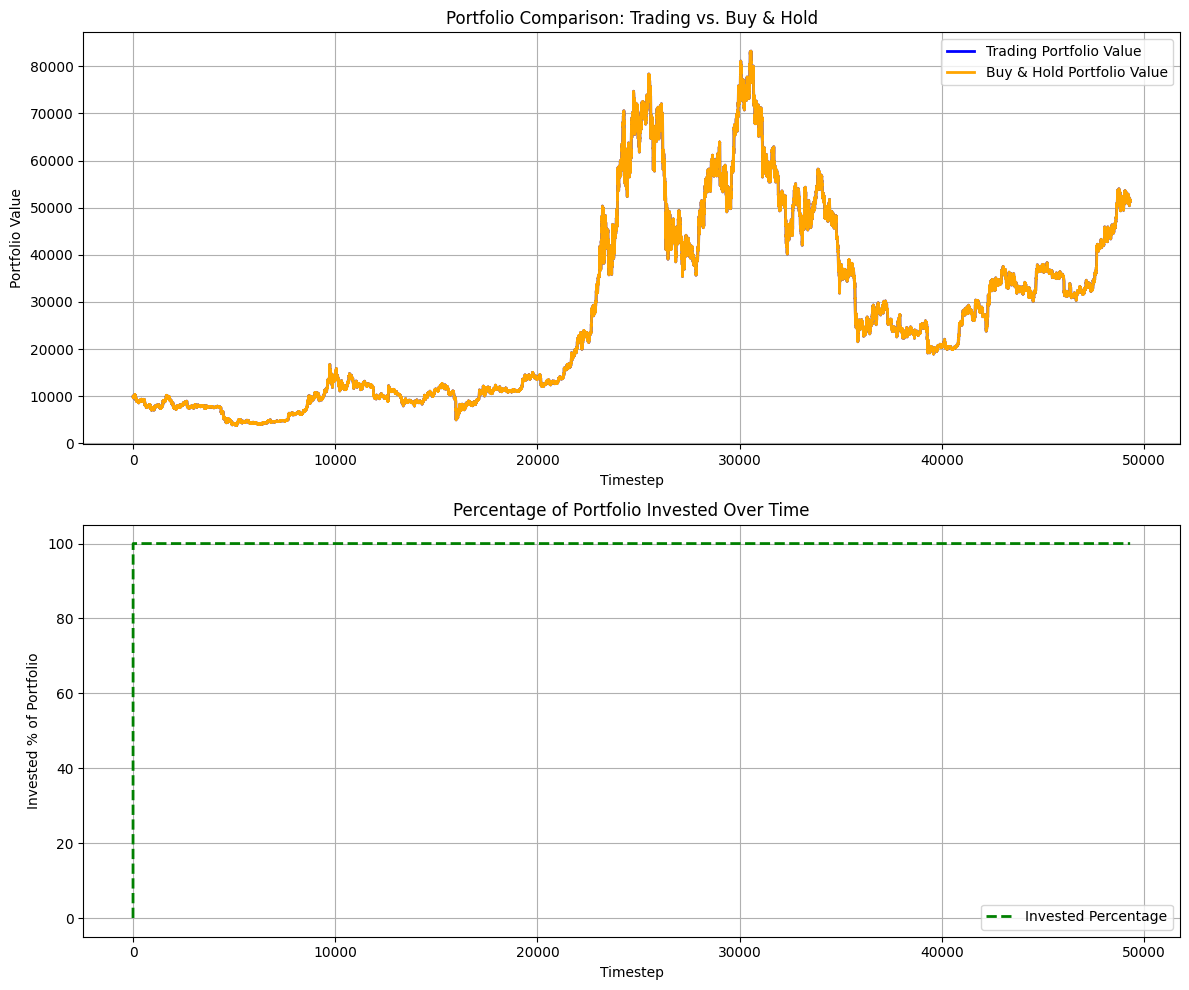

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [41]:
training_env = env

obs, info = training_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = training_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
training_env.render(mode='human')
print(action_list)

## Testdaten

Seed in the environment: 42
Seed in the environment: 42


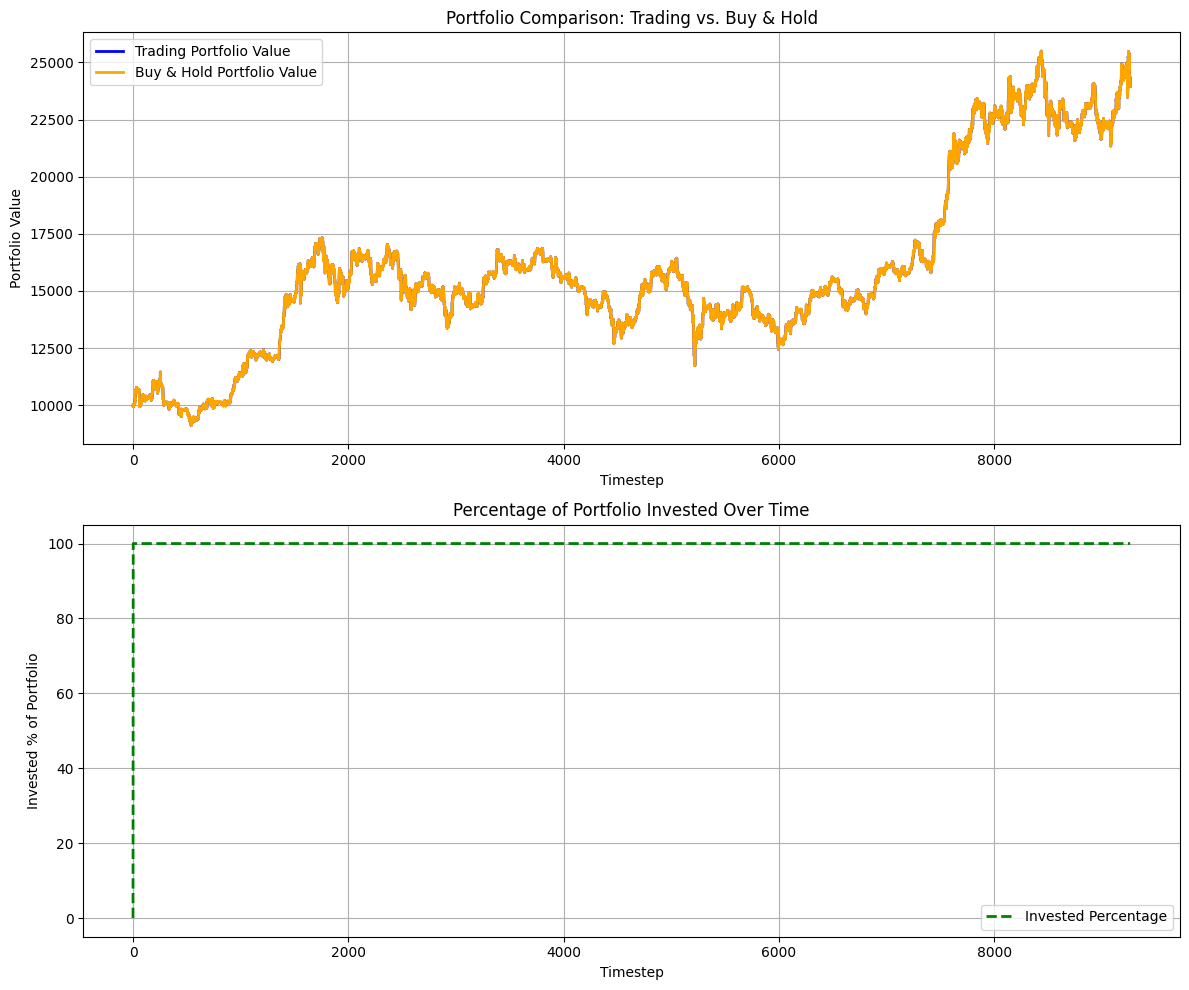

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [42]:
test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)